In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.font_manager as fm
from textwrap import wrap


prop = fm.FontProperties(fname='../plots/arial.ttf')

plt.rcParams['ps.useafm'] = True
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

from statsmodels.stats.multitest import multipletests

import sys
import os

sys.path.append(os.path.relpath("../../huygens"))
sys.path.append(os.path.relpath("../../galileo"))
import galileo as gal
import huygens as huy

from itertools import combinations,chain
import upsetplot

import json

import helper

# Load rMATS outputs

In [2]:
with open("experiments.json","r") as f:
    exp = json.load(f)
    
    experiments = exp["experiments"]
    experiment_ids = exp["experiment_ids"]
    display_names = exp["display_names"]
    display_groups = exp["display_groups"]
    contexts = exp["contexts"]


In [3]:
rpl22_oe_rmats = pd.read_hdf("../data/processed/rmats_merge/rpl22_oe.h5",key="rmats")
rpl22l1_oe_rmats = pd.read_hdf("../data/processed/rmats_merge/rpl22l1_oe.h5",key="rmats")
rpl22l1_kd1_rmats = pd.read_hdf("../data/processed/rmats_merge/rpl22l1_kd1.h5",key="rmats")
rpl22l1_kd2_rmats = pd.read_hdf("../data/processed/rmats_merge/rpl22l1_kd2.h5",key="rmats")
rpl22_a_ko1_rmats = pd.read_hdf("../data/processed/rmats_merge/rpl22_a_ko1.h5",key="rmats")
rpl22_a_ko2_rmats = pd.read_hdf("../data/processed/rmats_merge/rpl22_a_ko2.h5",key="rmats")
rpl22_b_ko1_rmats = pd.read_hdf("../data/processed/rmats_merge/rpl22_b_ko1.h5",key="rmats")
rpl22_b_ko2_rmats = pd.read_hdf("../data/processed/rmats_merge/rpl22_b_ko2.h5",key="rmats")

rpl22_oe_rmats = rpl22_oe_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22l1_oe_rmats = rpl22l1_oe_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22l1_kd1_rmats = rpl22l1_kd1_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22l1_kd2_rmats = rpl22l1_kd2_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22_a_ko1_rmats = rpl22_a_ko1_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22_a_ko2_rmats = rpl22_a_ko2_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22_b_ko1_rmats = rpl22_b_ko1_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22_b_ko2_rmats = rpl22_b_ko2_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)

splice_types = ["A3SS","A5SS","MXE","RI","SE"]

# Differential splicing

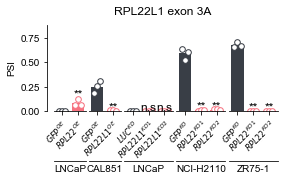

In [6]:
axes = helper.all_bars("RPL22L1_ENSG00000163584_170585801_170585990_170585801_170585923_170586086_170586176", 
     "splicing")
plt.suptitle("RPL22L1 exon 3A")

plt.savefig("../plots/RPL22L1_3A_splicing.pdf",bbox_inches="tight",transparent=True)

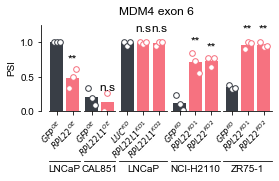

In [7]:
axes = helper.all_bars("MDM4_ENSG00000198625_204506557_204506625_204501318_204501374_204507336_204507436", 
     "splicing")

plt.suptitle("MDM4 exon 6")
plt.savefig("../plots/MDM4_6_splicing.pdf",bbox_inches="tight",transparent=True)

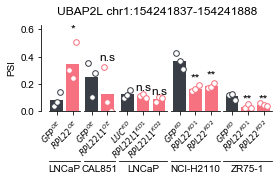

In [8]:
axes = helper.all_bars("UBAP2L_ENSG00000143569_154241837_154241888_154241232_154241430_154242675_154243040", 
     "splicing")

plt.suptitle("UBAP2L chr1:154241837-154241888")
plt.savefig("../plots/UBAP2L_splicing.pdf",bbox_inches="tight",transparent=True)

# Splicing types

In [9]:
def plot_splice_types(rmats_diffs, qval_cutoff=0.01, ax=None,legend=False):
    
    if ax is None:
        ax = plt.subplot(111)

    significants = rmats_diffs.copy(
        deep=True)[rmats_diffs["qval"] < qval_cutoff]

    significants["treatment_increase"] = significants["treatment_median"] > significants["control_median"]

    significants["treatment_increase"] = significants["treatment_increase"].replace({True: "Inclusion",
                                                                                     False: "Exclusion"})

    significants = significants.groupby(
        "splice_type")["treatment_increase"].value_counts()
    significants = significants.unstack()

    significants, _ = significants.align(
        pd.Series(index=splice_types), join="right", axis=0)
    significants = significants.fillna(0)

    significants["splice_type"] = significants.index
    
    significants.columns.name = ""
    
    significants.plot(x="splice_type",
                      y=["Exclusion", "Inclusion"],
                      kind="bar",
                      cmap=mpl.colors.ListedColormap(
                          ["#dbe2ef", "#3f72af"]),
                      ax=ax,
                      stacked=True,
                      width=0.8,
                      legend=legend
                      )
    
    plt.ylabel("Frequency")
    plt.xlabel("Splice type")
    
    plt.xticks(rotation=45,ha="right")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines['left'].set_position(('axes', -0.05))

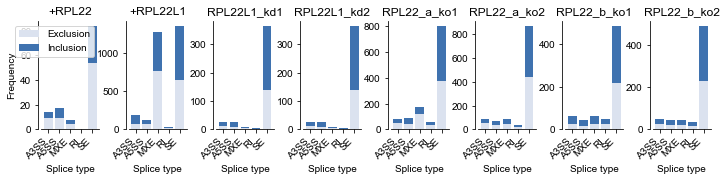

In [10]:
plt.figure(figsize=(12,2))
    
for experiment_idx, experiment in enumerate([rpl22_oe_rmats,
                                             rpl22l1_oe_rmats,
                                             rpl22l1_kd1_rmats,
                                             rpl22l1_kd1_rmats,
                                             rpl22_a_ko1_rmats,
                                             rpl22_a_ko2_rmats,
                                             rpl22_b_ko1_rmats,
                                             rpl22_b_ko2_rmats
                                            ]):

    ax = plt.subplot(1,8,experiment_idx+1)
    plot_splice_types(experiment,ax=ax,legend=experiment_idx<1)
    
    if experiment_idx > 0:
        plt.ylabel("")
        
    ax.set_title(display_names[experiment_idx])
        
plt.subplots_adjust(wspace=0.5)

plt.savefig("../plots/significant_splice_types.pdf",bbox_inches="tight",transparent=True)

# Overlaps

In [4]:
def get_overlaps(diffs,names,cutoff=0.01, direction=None, entity="exon", filter_empty=True):
    
    assert len(diffs)==len(names),"Length of diffs and names should match"

    n_diffs = len(diffs)
    all_subset_indices = list(chain(*[combinations(range(n_diffs), i) for i in range(1,n_diffs+1)]))
    
    significants = []
    
    for diff in diffs:
        
        if direction == None:
        
            significant = diff.copy(deep=True)[diff["qval"]<cutoff]
            
        if direction == "pos":
            
            significant = diff.copy(deep=True)[diff["qval"]<cutoff]
            significant = significant[significant["median_foldchange"]>=1]
            
        elif direction == "neg":
            
            significant = diff.copy(deep=True)[diff["qval"]<cutoff]
            significant = significant[significant["median_foldchange"]<1]
        
        if entity == "gene":
        
            significant_entities = set(significant["gene_id"])
            
        elif entity == "exon":
        
            significant_entities = set(significant.index)
        
        significants.append(significant_entities)
        
    intersections = []
    intersection_names = []
        
    for subset_indices in all_subset_indices:
        
        select_significants = set.intersection(*[significants[i] for i in subset_indices])
                
        if len(subset_indices) < n_diffs:
        
            select_insignificants = set.union(*[significants[i] for i in range(n_diffs) if i not in subset_indices])
        
            select_significants = select_significants - select_insignificants
        
        select_names = [names[i] for i in subset_indices]
        
        intersections.append(select_significants)
        intersection_names.append(select_names)
        
    intersection_sizes = [len(x) for x in intersections]
    
    if filter_empty:
        
        n_subsets = len(intersections)
        
        empty = [len(x) == 0 for x in intersections]
        
        intersections = [intersections[i] for i in range(n_subsets) if not empty[i]]
        intersection_names = [intersection_names[i] for i in range(n_subsets) if not empty[i]]
        intersection_sizes = [intersection_sizes[i] for i in range(n_subsets) if not empty[i]]
        
    return intersections,intersection_names,intersection_sizes

# Intersections

In [5]:
rpl22_int_rmats = [
    rpl22_b_ko2_rmats,
    rpl22_b_ko1_rmats,
    rpl22_a_ko2_rmats,
    rpl22_a_ko1_rmats,
    rpl22_oe_rmats,
]

rpl22_int_display_names = [
    "ZR75-1 $RPL22^{KO2}$",
    "ZR75-1 $RPL22^{KO1}$",
    "NCI-H2110 $RPL22^{KO2}$",
    "NCI-H2110 $RPL22^{KO1}$",
    "LNCaP $RPL22^{OE}$"
]

rpl22_ko_ints, rpl22_ko_int_names, rpl22_ko_int_sizes = get_overlaps(rpl22_int_rmats,rpl22_int_display_names)

In [6]:
rpl22_ko_pivot = upsetplot.from_memberships(rpl22_ko_int_names,rpl22_ko_int_sizes)

rpl22_ko_pivot = rpl22_ko_pivot.reorder_levels(rpl22_int_display_names)

In [8]:
rpl22_ko_ints[-1]

{'MDM4_ENSG00000198625_204506557_204506625_204501318_204501374_204507336_204507436',
 'MDM4_ENSG00000198625_204506586_204506625_204501318_204501374_204507336_204507436',
 'RPL22L1_ENSG00000163584_170585801_170585990_170585801_170585923_170586086_170586176',
 'UBAP2L_ENSG00000143569_154241837_154241888_154241232_154241430_154242675_154243040'}

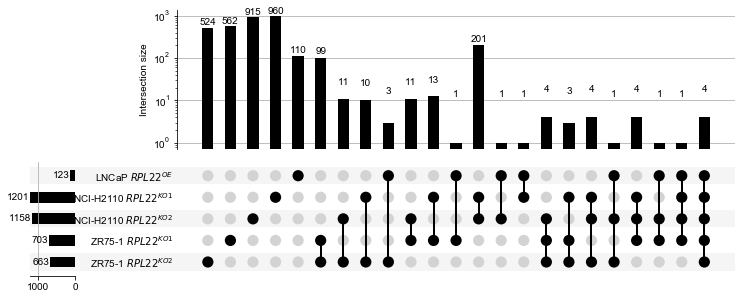

In [7]:
up = upsetplot.plot(rpl22_ko_pivot,
                    sort_categories_by=None, 
                    show_counts=True
                   )

up["intersections"].set_yscale("log")

plt.savefig("../plots/RPL22_exon_intersections.pdf",transparent=True,bbox_inches="tight")

In [199]:
rpl22l1_int_rmats = [
    rpl22l1_kd2_rmats,
    rpl22l1_kd1_rmats,
    rpl22l1_oe_rmats
]

rpl22l1_int_display_names = [
    "LNCaP $RPL22L1^{KD2}$",
    "LNCaP $RPL22L1^{KD1}$",
    "CAL851 $RPL22L1^{OE}$"
]

rpl22l1_ko_ints, rpl22l1_ko_int_names, rpl22l1_ko_int_sizes = get_overlaps(rpl22l1_int_rmats,rpl22l1_int_display_names)

In [200]:
rpl22l1_ko_pivot = upsetplot.from_memberships(rpl22l1_ko_int_names,rpl22l1_ko_int_sizes)

rpl22l1_ko_pivot = rpl22l1_ko_pivot.reorder_levels(rpl22l1_int_display_names)

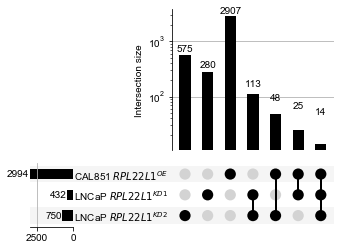

In [201]:
up = upsetplot.plot(rpl22l1_ko_pivot,
                    sort_categories_by=None, 
                    show_counts=True
                   )

up["intersections"].set_yscale("log")

plt.savefig("../plots/RPL22L1_exon_intersections.pdf",transparent=True,bbox_inches="tight")